# Imports

In [48]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

#
from IPython.display import display, clear_output
import sys
import time

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Some custom tools
from src.data.tools import check_for_missing_vals

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from atomm.Tools import calc_open_position
from src.visualization.visualize import plot_confusion_matrix

import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load environment variables
load_dotenv(find_dotenv())

True

## Defining functions

In [134]:
ti_list = ['macd', 'rsi', 'stoc', 'roc', 'bbu', 'bbl', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']

def run_combinations(
        symbol,
        forecast_horizon,
        input_window_size,
        X_train,
        X_test,
        y_train,
        y_test,
        prices,
        model,
        silent = False,
    ):
    start = time.time()
    cnt = 1
    df_score = pd.DataFrame(index=forecast_horizon, columns=input_window_size, dtype=float)
    df_score.rename_axis('Forecast horizon (days)').rename_axis('Input window (days)', axis=1)
    df_returns = df_score.copy()
    # Loop over forecast horizons
    for i, fh in enumerate(forecast_horizon):
        # Loop over input / lookback windows
        for j, iw in enumerate(input_window_size):
            total = len(forecast_horizon)*len(input_window_size)
            model.fit(X_train[symbol][[f'{x}_{iw}' for x in ti_list]], y_train[symbol][f'signal_{fh}'])
            y_pred = model.predict(X_test[symbol][[f'{x}_{iw}' for x in ti_list]])
            # Calculate accuracy score ()
            a_score = accuracy_score(y_test[symbol][f'signal_{fh}'], y_pred)
            # Calculate returns generated by stratedy
            returns = calc_returns(y_pred, prices[symbol])
            cum_returns = returns['Cum_Returns_Strat'][-1]
            df_score.iloc[i, j] = a_score
            df_returns.iloc[i, j] = cum_returns
            if silent == False:
                clear_output(wait=True)
                display(f'Leg [{cnt} / {total}]; Test Score {a_score}; Test Returns {cum_returns}')
            cnt += 1
    print(f'Elapsed time {round(time.time()-start, 0)}s.')
    return df_score, df_returns

In [123]:
def avg_model2(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=None,
    silent = False
):
    results_dict, returns_dict = {}, {}
    cnt = 1
    start = time.time()
    for symb in symbol_list:
        results, returns = run_combinations(
            symb,                             
            forecast_horizon,                                 
            input_window_size,                                  
            X_train,    
            X_test,    
            y_train,    
            y_test,    
            prices_test,   
            model=xgb_optm,
            silent=True
        )
        results_dict[symb] = results
        returns_dict[symb] = returns
        
        if silent == False:
            clear_output(wait=True)
            display(f'Leg [{cnt}/{len(symbol_list)}]; Elapsed Time {round(time.time()-start , 0)}s')
        cnt += 1
    avg_results = pd.DataFrame(
        np.array([results_dict[x].values for x in results_dict.keys()]).mean(axis=0),
        columns=results.columns, index=results.index).style.background_gradient(cmap='BuGn')
    return avg_results, results_dict, returns_dict

In [171]:
def avg_model(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model,
    silent = False
):
    results_dict, returns_dict = {}, {}
    cnt = 1
    start = time.time()
    for symb in symbol_list:
        results, returns = run_combinations(
            symb,                             
            forecast_horizon,                                 
            input_window_size,                                  
            X_train,    
            X_test,    
            y_train,    
            y_test,    
            prices_test,   
            model=xgb_optm,
            silent=True
        )
        results_dict[symb] = results
        returns_dict[symb] = returns
        avg_results = pd.DataFrame(
            np.array([results_dict[x].values for x in results_dict.keys()]).mean(axis=0),
            columns=results.columns, index=results.index).style.background_gradient(cmap='BuGn')
        
        if silent == False:
            clear_output(wait=True)
            display(f'Leg [{cnt}/{len(symbol_list)}]; Elapsed Time {round(time.time()-start , 0)}s\n', avg_results)
        cnt += 1

    return avg_results, results_dict, returns_dict

In [140]:
from sklearn.model_selection import BaseCrossValidator
class BlockingTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
        plt.figure(figsize=(8, 6))
        sns.heatmap(df_score, annot=True, fmt='.2f', cmap='RdBu')
        plt.ylabel('Forecast horizon (days)')
        plt.xlabel('Input window size (days)')
        plt.tight_layout()
        plt.figure(figsize=(8, 6))
        sns.heatmap(df_returns, annot=True, fmt='.2f', cmap='RdBu')
        plt.ylabel('Forecast horizon (days)')
        plt.xlabel('Input window size (days)')
        plt.ylim(len(forecast_horizon)-0.5, -0.5)
        plt.tight_layout()

In [4]:
def calc_returns(signals, prices):
    returns = prices[['Close']].pct_change()
    returns['Signal_Strat'] = calc_open_position(signals)
    returns['Cum_Returns_Strat'] = (returns['Signal_Strat'] * returns['Close']).cumsum()
    returns['Cum_Returns_BH'] = returns['Close'].cumsum()
    return returns

## Loading the data

In [6]:
# Load dataset from pickle file
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')
#fname = data_base_dir + '/processed/djia_features_2019-12-19.pkl'
#X = pickle.load(open(fname, 'rb'))

fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
with pd.HDFStore(fname) as storage:
    djia = storage.get('nyse/cleaned/rand_symbols')
    y_2c = storage.get('nyse/engineered/target_two_class')
    y_3c = storage.get('nyse/engineered/target_three_class')
    df_moments = storage.get('nyse/engineered/features')
    #print(storage.info())
    
#fname1 = data_base_dir + '/processed/djia_target_y_2c_2019-12-19.pkl'
#y_2c = pickle.load(open(fname1, 'rb'))

#fname2 = data_base_dir + '/processed/djia_target_y_3c_2019-12-19.pkl'
#y_3c = pickle.load(open(fname2, 'rb'))

In [103]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]
symbol_list = df_moments.columns.get_level_values(0).unique()

In [7]:
X = df_moments.copy()
y = y_3c.copy()
prices = djia.copy()

## Imputing missing values

### X values

In [8]:
X.shape

(1954, 4800)

In [9]:
check_for_missing_vals(X)

No missing values found in dataframe


Prices values

In [10]:
prices.shape

(1954, 250)

In [11]:
check_for_missing_vals(prices)

No missing values found in dataframe


In [12]:
y_3c.shape

(1954, 450)

In [13]:
check_for_missing_vals(y_3c)

No missing values found in dataframe


No missing values, and sizes of ```y.shape[0]``` and```X.shape[0]``` match.

## Scaling the features

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [15]:
#scale = MinMaxScaler()
scale = StandardScaler()

In [16]:
scaled = scale.fit_transform(X)

In [17]:
scaled.shape

(1954, 4800)

In [18]:
X_scaled = pd.DataFrame(data=scaled, columns=X.columns)
#X_scaled = X

In [19]:
X_scaled.describe()

CNC                                                         \
             macd_3         rsi_3        stoc_3        roc_3         bbu_3   
count  1.954000e+03  1.954000e+03  1.954000e+03  1954.000000  1.954000e+03   
mean   3.636350e-18 -7.090882e-17  5.272707e-17     0.000000  1.163632e-16   
std    1.000256e+00  1.000256e+00  1.000256e+00     1.000256  1.000256e+00   
min   -1.833054e+01 -1.609272e+00 -1.199358e+00   -11.824073 -1.541813e+00   
25%   -2.111012e-01 -8.611892e-01 -1.199358e+00    -0.400709 -9.271855e-01   
50%    7.404414e-02  8.804916e-02  2.723452e-01     0.049713  4.140896e-02   
75%    3.451248e-01  8.965048e-01  1.008199e+00     0.497405  5.006855e-01   
max    2.163374e+00  1.344672e+00  1.008199e+00     4.721545  3.444957e+00   

                                                                            \
             bbl_3         ema_3         atr_3         adx_3         cci_3   
count  1954.000000  1.954000e+03  1.954000e+03  1.954000e+03  1.954000e+03   
mean      0.000000  3.490896e-16 -2.909080e-17  5.727251e-17 -3.272715e-17   
std       1.000256  1.000256e+00  1.000256e+00  1.000256e+00  1.000256e+00   
min      -2.368444 -1.522486e+00 -1.002532e+00 -1.704075e+00 -1.368580e+00   
25%      -0.909548 -9.275074e-01 -5.990103e-01 -8.133477e-01 -1.109236e+00   
50%       0.028471  3.234966e-02 -1.612422e-01 -1.598737e-01  2.317152e-01   
75%       0.527297  5.179050e-01  3.266013e-01  7.100043e-01  1.063843e+00   
max       3.267566  3.179516e+00  1.796977e+01  3.191108e+00  1.129246e+00   

       ...          MSFT                                           \
       ...       stoc_30        roc_30        bbu_30       bbl_30   
count  ...  1.954000e+03  1.954000e+03  1.954000e+03  1954.000000   
mean   ...  2.036356e-16 -2.545445e-17  5.818160e-17     0.000000   
std    ...  1.000256e+00  1.000256e+00  1.000256e+00     1.000256   
min    ... -2.088478e+00 -2.912346e+00 -1.146329e+00    -1.146198   
25%    ... -7.158311e-01 -6.073142e-01 -7.928107e-01    -0.777805   
50%    ...  2.481511e-01 -2.122579e-02 -3.393523e-01    -0.400524   
75%    ...  8.892578e-01  5.697624e-01  6.917349e-01     0.624969   
max    ...  1.131873e+00  3.678414e+00  2.534088e+00     2.630559   

                                                                            \
             ema_30        atr_30        adx_30       cci_30  williamsr_30   
count  1.954000e+03  1.954000e+03  1.954000e+03  1954.000000  1.954000e+03   
mean  -2.327264e-16 -1.163632e-16  2.909080e-17     0.000000  7.272699e-17   
std    1.000256e+00  1.000256e+00  1.000256e+00     1.000256  1.000256e+00   
min   -1.102559e+00 -1.102141e+00 -1.872236e+00    -4.143208 -1.345955e+00   
25%   -7.908250e-01 -6.705596e-01 -7.438048e-01    -0.621499 -8.612115e-01   
50%   -3.209191e-01 -3.674548e-01 -1.143978e-01     0.138609 -2.020590e-01   
75%    6.472043e-01  2.052438e-01  5.667183e-01     0.664610  7.058919e-01   
max    2.519066e+00  3.590757e+00  3.202525e+00     3.755891  2.375945e+00   

                     
           stocd_30  
count  1.954000e+03  
mean   1.018178e-16  
std    1.000256e+00  
min   -2.481194e+00  
25%   -7.670362e-01  
50%    2.340983e-01  
75%    8.401506e-01  
max    1.588080e+00  

[8 rows x 4800 columns]

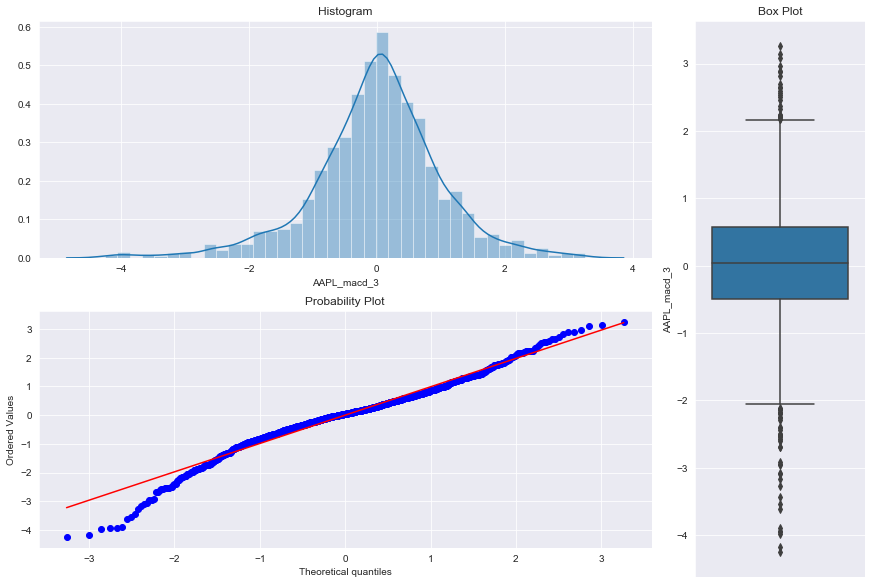

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.gridspec as gridspec
#import matplotlib.style as style
from scipy import stats
sns.set_style('darkgrid')
#style.use('fivethirtyeight')
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Histogram')
sns.distplot(X_scaled['AAPL_macd_3'], norm_hist=False, ax = ax1)

ax2 = fig.add_subplot(grid[1, :2])
ax2.set_title('QQ_plot')
stats.probplot(X_scaled['AAPL_macd_3'], plot = ax2)

ax3 = fig.add_subplot(grid[:, 2])
ax3.set_title('Box Plot')
sns.boxplot(X_scaled['AAPL_macd_3'], orient='v', ax = ax3 );

## Building Machine Learning Models

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

### Train-Test Split

In [21]:
test_p = .3

In [22]:
test_size = int((1 - test_p) * X_scaled.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_3c[:test_size], y_3c[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [372]:
prices_test.head()

CNC                                   \
                                Open       High        Low      Close   
Epoch                                                                   
2017-07-11 00:00:00+00:00  81.800003  82.919998  81.290001  81.980003   
2017-07-12 00:00:00+00:00  82.370003  82.870003  81.680000  82.500000   
2017-07-13 00:00:00+00:00  82.489998  82.720001  81.519997  82.400002   
2017-07-14 00:00:00+00:00  82.709999  83.389999  82.330002  82.800003   
2017-07-17 00:00:00+00:00  82.970001  83.930000  82.610001  83.690002   

                                          FMC                        \
                            Volume       Open       High        Low   
Epoch                                                                 
2017-07-11 00:00:00+00:00  1648800  75.559998  75.589996  73.930000   
2017-07-12 00:00:00+00:00  1805200  74.970001  75.660004  74.870003   
2017-07-13 00:00:00+00:00  1389500  75.900002  77.050003  75.400002   
2017-07-14 00:00:00+00:00  1746500  76.989998  77.220001  76.389999   
2017-07-17 00:00:00+00:00  1620800  76.449997  77.180000  76.449997   

                                               ...         IBM              \
                               Close   Volume  ...        Open        High   
Epoch                                          ...                           
2017-07-11 00:00:00+00:00  74.230003  1308100  ...  153.259995  153.649994   
2017-07-12 00:00:00+00:00  75.529999   793100  ...  153.479996  154.240005   
2017-07-13 00:00:00+00:00  76.830002  1402200  ...  153.699997  154.190002   
2017-07-14 00:00:00+00:00  76.489998   894200  ...  154.009995  154.619995   
2017-07-17 00:00:00+00:00  76.779999   739000  ...  153.589996  153.880005   

                                                                 MSFT  \
                                  Low       Close   Volume       Open   
Epoch                                                                   
2017-07-11 00:00:00+00:00  152.050003  153.190002  3447509  70.000000   
2017-07-12 00:00:00+00:00  153.050003  153.699997  3097850  70.690002   
2017-07-13 00:00:00+00:00  153.190002  153.630005  2476112  71.500000   
2017-07-14 00:00:00+00:00  153.399994  154.240005  3256372  72.239998   
2017-07-17 00:00:00+00:00  152.240005  153.009995  4762592  72.800003   

                                                                      
                                High        Low      Close    Volume  
Epoch                                                                 
2017-07-11 00:00:00+00:00  70.680000  69.750000  69.989998  17460022  
2017-07-12 00:00:00+00:00  71.279999  70.550003  71.150002  17750925  
2017-07-13 00:00:00+00:00  72.040001  71.309998  71.769997  20269816  
2017-07-14 00:00:00+00:00  73.269997  71.959999  72.779999  25868086  
2017-07-17 00:00:00+00:00  73.449997  72.720001  73.349998  21803907  

[5 rows x 250 columns]

In [46]:
test_size = test_p
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_3c, test_size=test_size, random_state=101)

### LogisticRegression

In [352]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=25, solver='newton-cg')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

ValueError: bad input shape (1172, 450)

### RandomForestClassifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [11]:
from src.models.hyperparameter_optimization import search_space

In [16]:
search_space(SVC)

NameError: name 'KNeighborsClassifier' is not defined

#### Single combination

              precision    recall  f1-score   support

          -1       0.69      0.14      0.24       126
           0       0.48      0.34      0.40       297
           1       0.35      0.75      0.48       164

    accuracy                           0.41       587
   macro avg       0.51      0.41      0.37       587
weighted avg       0.49      0.41      0.38       587

[[ 18  68  40]
 [  8 100 189]
 [  0  41 123]]


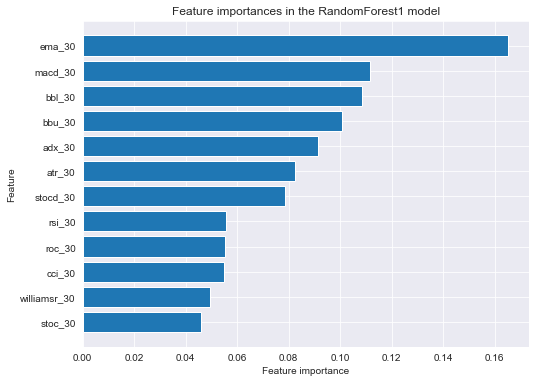

In [374]:
symbol = 'T'
col = 'AAPL_signal_30'
n = 30
rf1 = RandomForestClassifier()
rf1.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])
y_pred_rf1 = rf1.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])

print(classification_report(y_test[symbol][f'signal_{n}'], y_pred_rf1))
print(confusion_matrix(y_test[symbol][f'signal_{n}'], y_pred_rf1))
plot_feature_importances(rf1.feature_importances_,
                         X_scaled[symbol][[f'{x}_{n}' for x in ti_list]].columns,
                         model='RandomForest1', top_count=100)

In [375]:
calc_returns(y_pred_rf1, prices_test[symbol])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,0,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,0,0.000000,0.006284
2017-07-13 00:00:00+00:00,-0.016834,0,0.000000,-0.010550
2017-07-14 00:00:00+00:00,0.002486,0,0.000000,-0.008064
2017-07-17 00:00:00+00:00,0.002479,0,0.000000,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,0,0.251065,0.105152
2019-11-01 00:00:00+00:00,0.011951,0,0.251065,0.117103
2019-11-04 00:00:00+00:00,-0.001540,0,0.251065,0.115563


#### All combinations

'Leg [72 / 72]; Test Score 0.42078364565587734; Test Returns 0.2707599997520447'

Elapsed time 27.0s.


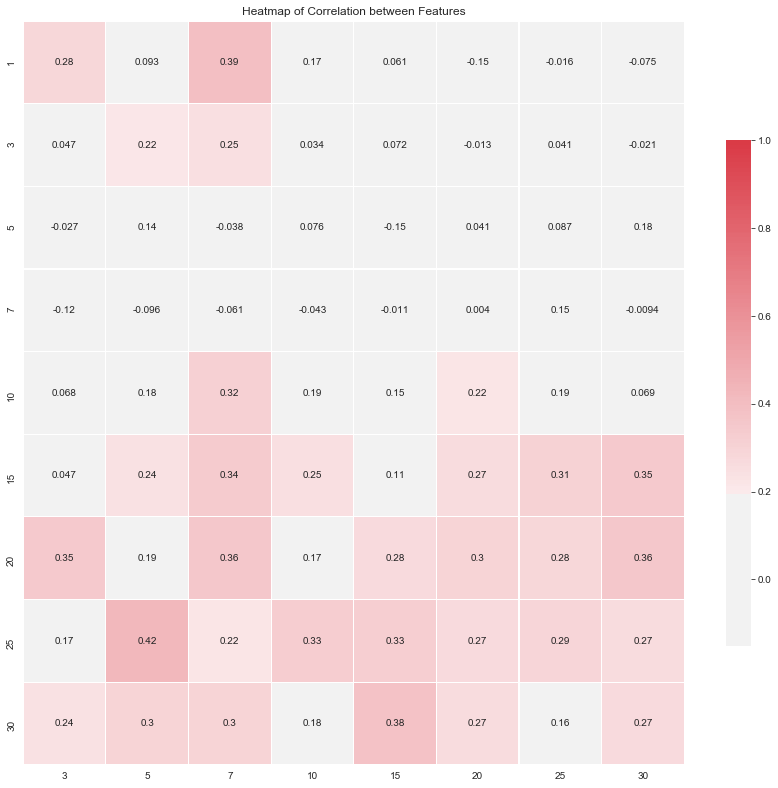

In [381]:
rf2 = RandomForestClassifier(criterion='gini')
score_mat, return_mat = run_combinations(
    symbol,
    forecast_horizon,
    input_window_size,
    X_train,
    X_test,
    y_train,
    y_test,
    prices_test,
    rf2
)

plot_corr_matrix(return_mat, mask_upper=False, show_annot=True)

### XGBoost

#### Single combination

In [391]:
import xgboost as xgb

In [389]:
symbol = 'T'
n = 30

xgb = xgb.XGBClassifier(n_jobs=-1)
xgb.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])

#param_search = {'max_depth' : [3, 5]}

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

              precision    recall  f1-score   support

          -1       0.55      0.18      0.27       126
           0       0.44      0.29      0.35       297
           1       0.35      0.76      0.48       164

    accuracy                           0.40       587
   macro avg       0.45      0.41      0.37       587
weighted avg       0.44      0.40      0.37       587

[[ 23  69  34]
 [ 17  85 195]
 [  2  38 124]]


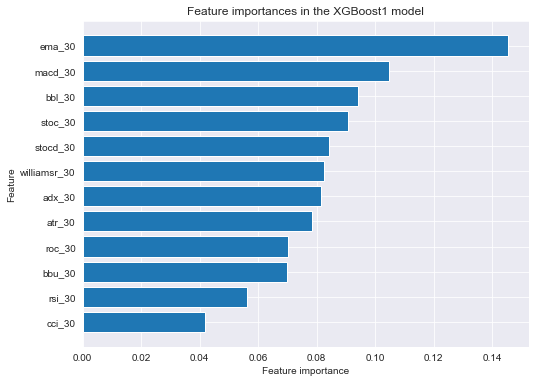

In [384]:
y_pred_xgb = xgb.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print(classification_report(y_test[symbol][f'signal_{n}'], y_pred_xgb))
print(confusion_matrix(y_test[symbol][f'signal_{n}'], y_pred_xgb))
plot_feature_importances(xgb.feature_importances_,
                         X_scaled[symbol][[f'{x}_{n}' for x in ti_list]].columns, 
                         model='XGBoost1', top_count=100)

In [ ]:
xgb.plot_importance(reg, height=0.9)

#### All combinations

'Leg [72 / 72]; Test Score 0.3833049403747871; Test Returns 0.2593308687210083'

Elapsed time 54.0s.


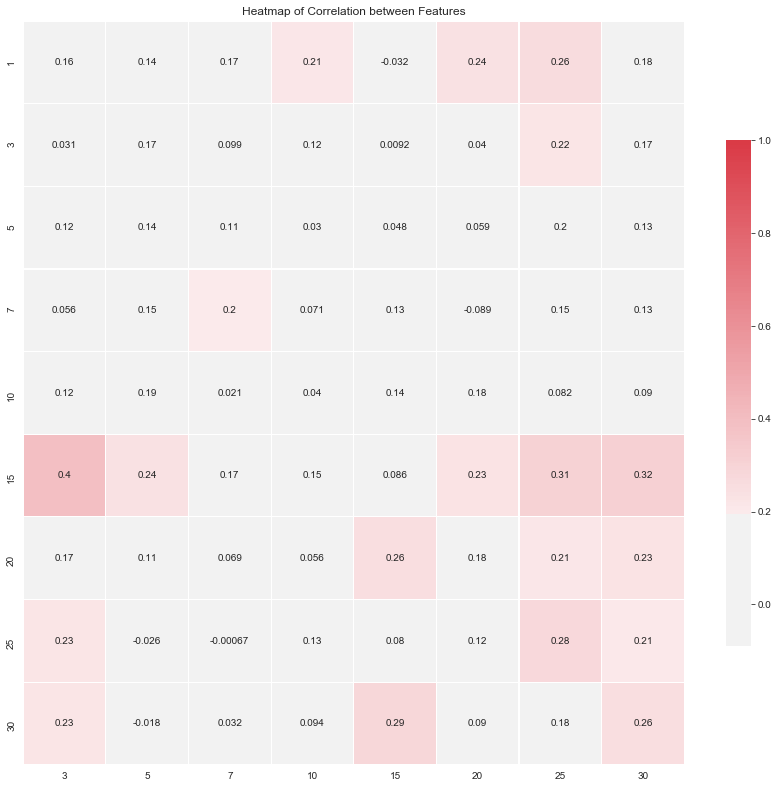

In [410]:
xgb_comb = xgb.XGBClassifier(n_jobs=-1, learning_rate=0.05, n_estimators=200)
results_xgb, returns_xgb = run_combinations('T',
                                 forecast_horizon,
                                 input_window_size, 
                                 X_train,
                                 X_test,
                                 y_train,
                                 y_test,
                                 prices_test,
                                 xgb_comb)

plot_corr_matrix(returns_xgb, mask_upper=False, show_annot=True)

### Support Vector Machine

In [127]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
#result_matrix = svc.fit('AAPL', forecast_horizon, input_window_size, X_train, X_test, y_train, y_test, svc)

svc.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [405]:
y_pred_svc = svc.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print(classification_report(y_test[symbol][f'signal_{n}'], y_pred_xgb))
print(confusion_matrix(y_test[symbol][f'signal_{n}'], y_pred_xgb))
#plot_feature_importances(svc.coef_,
#                         X_scaled[symbol][[f'{x}_{n}' for x in ti_list]].columns, 
#                         model='SVC1', top_count=100)

              precision    recall  f1-score   support

          -1       0.55      0.18      0.27       126
           0       0.44      0.29      0.35       297
           1       0.35      0.76      0.48       164

    accuracy                           0.40       587
   macro avg       0.45      0.41      0.37       587
weighted avg       0.44      0.40      0.37       587

[[ 23  69  34]
 [ 17  85 195]
 [  2  38 124]]


#### All combinations

'Leg [72 / 72]; Test Score 0.4991482112436116; Test Returns 0.33731043338775635'

Elapsed time 7.0s.


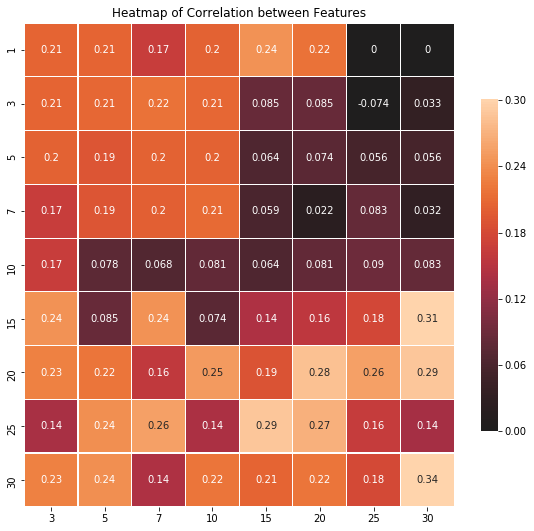

In [131]:
svm2 = SVC(degree=12)
score_svm, returns_svm = run_combinations(
    symbol,
    forecast_horizon,
    input_window_size,
    X_train,
    X_test,
    y_train,
    y_test,
    prices_test,
    svm2
)

plot_corr_matrix(returns_svm, mask_upper=False, show_annot=True, figsize=(8, 8))

#### Averaging across all 50 randomly selected stocks

In [172]:
avg, _, _ = avg_model(
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    svm2,
    silent = False
)

'Leg [50/50]; Elapsed Time 337.0s\n'

,3,5,7,10,15,20,25,30
1,0.413629,0.41339,0.411721,0.412368,0.409506,0.413663,0.414037,0.412129
3,0.406065,0.406814,0.409165,0.407836,0.406951,0.410971,0.411959,0.414514
5,0.402078,0.405486,0.406917,0.405077,0.408893,0.407939,0.406337,0.408382
7,0.40644,0.406746,0.40586,0.402351,0.406678,0.40954,0.406303,0.413799
10,0.407836,0.407359,0.407019,0.40385,0.408041,0.409915,0.408825,0.405451
15,0.402589,0.408484,0.400818,0.402249,0.405554,0.406269,0.39816,0.397683
20,0.396491,0.398705,0.398637,0.394719,0.397922,0.397002,0.39925,0.396559
25,0.397615,0.394617,0.398126,0.396934,0.400443,0.401193,0.399761,0.396899
30,0.396048,0.394991,0.395707,0.392811,0.397683,0.406269,0.401704,0.398535


### Hyperparamter Optimization: GridSearch

In [ ]:
symbol = 'T'
n = 30
start = time.time()

# kernel = 'rbf', 'linear, 'poly'
# gamma only for non-linear kernels (poly, rbf)
# C penalty for error term
# degrees = [0, 1, 2, 3, 4, 5, 6] only for kernel = poly
gammas = [10, 1, 0.1, 0.01, 0.001, 1E-4, 1E-5, 1E-6]
cs = [1, 10, 100, 1000, 1E4, 1E5, 1E6]
param_search = [
    {'kernel': ['rbf'], 'gamma': gammas, 'C': cs},
    #{'kernel': ['poly'], 'gamma': gammas, 'C': cs, 'degree' : [0, 1, 2, 3, 4, 5, 6]},
    #{'kernel': ['linear'], 'C': cs}
]

tscv = TimeSeriesSplit(n_splits=5)
svm_gs = SVC()
gsearch_svc = GridSearchCV(
    estimator=svm_gs,                   
    cv=tscv,      
    param_grid=param_search,                      
    scoring = 'accuracy',
    n_jobs=-1
)
gsearch_svc.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])
print(f'Elapsed time: {round(time.time()-start, 0)}s')

In [166]:
from sklearn.model_selection import cross_val_score

In [175]:
estimator = gsearch_svc.best_estimator_
cvs = cross_val_score(
    estimator, 
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    cv=tscv
)
results = pd.DataFrame(gsearch_svc.cv_results_)
print('##### Results #####')
print('Score best parameters: ', gsearch_svc.best_score_)
print('Best parameters: ', gsearch_svc.best_params_)
print('Cross-validation Score: ', cvs.mean())
print('Test Score: ', estimator.score(X_test[symbol][[f'{x}_{n}' for x in ti_list]], y_test[symbol][f'signal_{n}']))
print('Parameter combinations evaluated: ', results.shape[0])

##### Results #####
Score best parameters:  0.5876651982378854
Best parameters:  {'C': 10, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
Cross-validation Score:  0.5876651982378854
Test Score:  0.5059625212947189
Parameter combinations evaluated:  164


In [163]:
gsearch_svc.best_score_

0.5876651982378854

### Hyperparamter Optimization: Bayesian Optimization

In [ ]:
def BayesianSearch(param_space, model, X_train, y_train, X_test, y_test, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        clf = model(**params)
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(
        objective_function, 
        param_space, 
        algo=tpe.suggest, 
        max_evals=num_eval, 
        trials=trials,
        rstate= np.random.RandomState(1)
    )
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        boosting_type = 'gbdt'
    else:
        boosting_type= 'dart'
    
    clf_best = model(
        learning_rate=best_param_values[2],
        num_leaves=int(best_param_values[5]),
        max_depth=int(best_param_values[3]),
        n_estimators=int(best_param_values[4]),
        boosting_type=boosting_type,
        colsample_bytree=best_param_values[1],
        reg_lambda=best_param_values[6],
    )
                                  
    clf_best.fit(X_train, y_train)
    
    print('##### Results #####')
    print('Score best parameters: ', min(loss)*-1)
    print('Best parameters: ', best_param)
    print('Test Score: ', clf_best.score(X_test, y_test))
    print('Parameter combinations evaluated: ', num_eval)
    print('Time elapsed: ', time.time() - start)

    


In [ ]:
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time

In [ ]:
param_hyperopt= {
    'gamma': hp.loguniform('gamma', np.log(1E-15), np.log(1)),
    'C': hp.loguniform('C', np.log(1), np.log(1E10)),
}

bsearch_svm = BayesianSearch(
    param_space=,
    model,
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    num_eval=75
)

#### Running on all 50 stocksavg_results

In [170]:
avg, _, _ = avg_model(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=gsearch_svc.best_estimator_,
    silent = False
)

'Leg [50/50]; Elapsed Time 329.0s'

In [159]:
avg

,3,5,7,10,15,20,25,30
1,0.413629,0.41339,0.411721,0.412368,0.409506,0.413663,0.414037,0.412129
3,0.406065,0.406814,0.409165,0.407836,0.406951,0.410971,0.411959,0.414514
5,0.402078,0.405486,0.406917,0.405077,0.408893,0.407939,0.406337,0.408382
7,0.40644,0.406746,0.40586,0.402351,0.406678,0.40954,0.406303,0.413799
10,0.407836,0.407359,0.407019,0.40385,0.408041,0.409915,0.408825,0.405451
15,0.402589,0.408484,0.400818,0.402249,0.405554,0.406269,0.39816,0.397683
20,0.396491,0.398705,0.398637,0.394719,0.397922,0.397002,0.39925,0.396559
25,0.397615,0.394617,0.398126,0.396934,0.400443,0.401193,0.399761,0.396899
30,0.396048,0.394991,0.395707,0.392811,0.397683,0.406269,0.401704,0.398535


### XGBoost with GridSearchCV

In [139]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

ImportError: cannot import name '_BaseKFold' from 'sklearn.model_selection' (//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/model_selection/__init__.py)

In [24]:
symbol = 'T'
n = 30

In [55]:
start = time.time()
param_search = {
    'learning_rate'    : [ 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 1 ],
    'max_depth'        : [ 3, 4, 5, 6, 8, 10, 12, 15 ],
    'min_child_weight' : [ 1, 3, 5, 7 ],
    'gamma'            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    'colsample_bytree' : [ 0.1, 0.3, 0.4, 0.5 , 0.7 ],
    'n_estimators'     : [ 50, 100, 500 ]
}

tscv = TimeSeriesSplit(n_splits=5)
xgb_cv = xgb.XGBClassifier(n_jobs=-1, nthreads=-1)
gsearch = GridSearchCV(
    estimator=xgb_cv,                   
    cv=tscv,      
    param_grid=param_search,                      
    scoring = 'accuracy',
    n_jobs=-1
)
gsearch.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])
print(f'Elapsed time: {round(time.time()-start, 0)}s')

Elapsed time: 11326.0s


In [56]:
gsearch.best_score_

0.5515418502202645

In [57]:
gsearch.best_params_

{'colsample_bytree': 0.1,
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 50}

In [66]:
y_pred_xgbcv = gsearch.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print(classification_report(y_test[symbol][f'signal_{n}'], y_pred_xgbcv))
print(confusion_matrix(y_test[symbol][f'signal_{n}'], y_pred_xgbcv))
#plot_feature_importances(gsearch.feature_importances_, X_scaled.columns, model='XGBoostGridSearchCV', top_count=100)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       126
           0       0.48      0.76      0.59       297
           1       0.35      0.26      0.29       164

    accuracy                           0.46       587
   macro avg       0.28      0.34      0.30       587
weighted avg       0.34      0.46      0.38       587

[[  0 118   8]
 [  0 226  71]
 [  0 122  42]]


//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Re-run on all lookback/lookahead window combination 

In [61]:
# Use optimal estimator from previous grid search to build new model
xgb_optm = gsearch.best_estimator_
print(xgb_optm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, nthreads=-1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)


In [71]:
xgb_comb2 = xgb.XGBClassifier(n_jobs=-1)
results_xgb2, returns_xgb2 = run_combinations(
    symbol,                             
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,   
    xgb_comb2
)

In [160]:
results_xgb2.style.background_gradient(cmap='BuGn')

,3,5,7,10,15,20,25,30
1,0.432709,0.427598,0.422487,0.436116,0.335605,0.422487,0.427598,0.386712
3,0.310051,0.301533,0.337308,0.311755,0.330494,0.420784,0.456559,0.422487
5,0.218058,0.20954,0.240204,0.228279,0.270869,0.286201,0.274276,0.306644
7,0.444634,0.437819,0.444634,0.441227,0.453152,0.400341,0.471891,0.415673
10,0.495741,0.482112,0.511073,0.471891,0.499148,0.504259,0.492334,0.46678
15,0.465077,0.471891,0.478705,0.459966,0.46678,0.468484,0.463373,0.459966
20,0.410562,0.402044,0.364566,0.407155,0.429302,0.456559,0.495741,0.495741
25,0.436116,0.434412,0.436116,0.422487,0.432709,0.449744,0.437819,0.451448
30,0.412266,0.413969,0.422487,0.412266,0.412266,0.425894,0.434412,0.436116


#### Averaging across all 50 randomly selected stocks

In [105]:
results_dict, returns_dict = {}, {}
cnt = 1
start = time.time()
for symb in symbol_list:
    results_xgb2, returns_xgb2 = run_combinations(
        symb,                             
        forecast_horizon,                                 
        input_window_size,                                  
        X_train,    
        X_test,    
        y_train,    
        y_test,    
        prices_test,   
        model=xgb_optm,
        silent=True
    )
    results_dict[symb] = results_xgb2
    returns_dict[symb] = returns_xgb2
    clear_output(wait=True)
    display(f'Leg [{cnt}/{len(symbol_list)}]; Elapsed Time {round(time.time()-start , 0)}s')
    cnt += 1

'Leg [50/50]; Elapsed Time 351.0'

,3,5,7,10,15,20,25,30
0,0.413629,0.41339,0.411721,0.412368,0.409506,0.413663,0.414037,0.412129
1,0.406065,0.406814,0.409165,0.407836,0.406951,0.410971,0.411959,0.414514
2,0.402078,0.405486,0.406917,0.405077,0.408893,0.407939,0.406337,0.408382
3,0.40644,0.406746,0.40586,0.402351,0.406678,0.40954,0.406303,0.413799
4,0.407836,0.407359,0.407019,0.40385,0.408041,0.409915,0.408825,0.405451
5,0.402589,0.408484,0.400818,0.402249,0.405554,0.406269,0.39816,0.397683
6,0.396491,0.398705,0.398637,0.394719,0.397922,0.397002,0.39925,0.396559
7,0.397615,0.394617,0.398126,0.396934,0.400443,0.401193,0.399761,0.396899
8,0.396048,0.394991,0.395707,0.392811,0.397683,0.406269,0.401704,0.398535


In [498]:
X1 = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y1 = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSâeriesSplit()
print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X1):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    print(X_train, X_test)

TimeSeriesSplit(max_train_size=None, n_splits=5)
TRAIN: [0] TEST: [1]
[[1 2]] [[3 4]]
TRAIN: [0 1] TEST: [2]
[[1 2]
 [3 4]] [[1 2]]
TRAIN: [0 1 2] TEST: [3]
[[1 2]
 [3 4]
 [1 2]] [[3 4]]
TRAIN: [0 1 2 3] TEST: [4]
[[1 2]
 [3 4]
 [1 2]
 [3 4]] [[1 2]]
TRAIN: [0 1 2 3 4] TEST: [5]
[[1 2]
 [3 4]
 [1 2]
 [3 4]
 [1 2]] [[3 4]]


## Unsupervised Learning

### KMeans Clustering

In [738]:
from sklearn.cluster import KMeans

In [763]:
kmeans = KMeans(
    n_clusters=3,
    verbose=0,
    tol=1E-3,
    max_iter=1000,
    n_init=20,
    random_state=3
)

In [764]:
kmeans.fit(X_scaled[['AAPL_macd_10', 'AAPL_williamsr_10']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=3, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=3, tol=0.001, verbose=0)

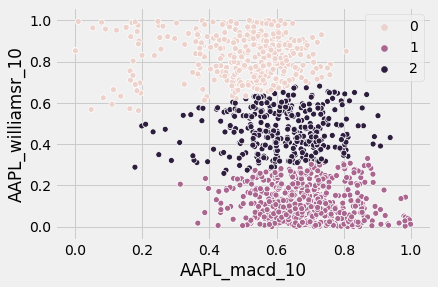

In [765]:
sns.scatterplot(X_scaled['AAPL_macd_10'], X_scaled['AAPL_williamsr_10'], hue=kmeans.labels_)

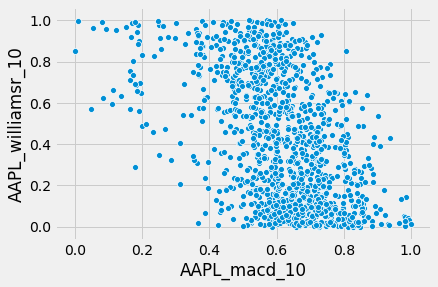

In [766]:
sns.scatterplot(X_scaled['AAPL_macd_10'], X_scaled['AAPL_williamsr_10'])